<a href="https://www.kaggle.com/code/yahyasoker/sentiment-analysis-using-pytorch?scriptVersionId=155034589" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# nltk is one of the most useful libraries when it comes to nlp
!pip install nltk

# 1. Importing libraries

In [2]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk

nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Models
import torch
from tqdm import tqdm
torch.cuda.is_available()
# To ignore warinings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

In [3]:
df = pd.read_csv('/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


# 2.Data Visualization

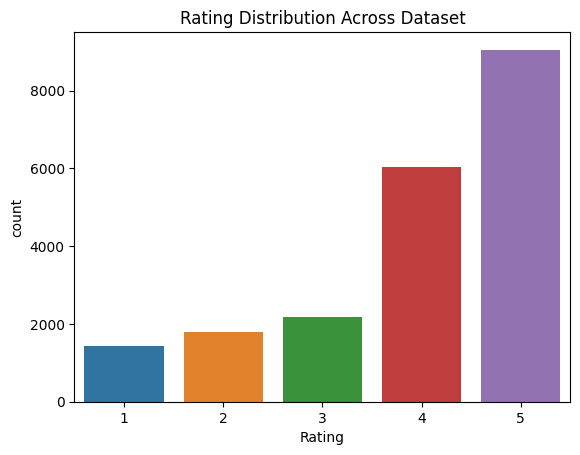

In [5]:
sns.countplot(data=df, x='Rating').set_title('Rating Distribution Across Dataset')
plt.show()

In [6]:
# Length of word in sentence
df['Length'] = df['Review'].apply(lambda r: len(r.split(" ")))
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,89
1,ok nothing special charge diamond member hilto...,2,252
2,nice rooms not 4* experience hotel monaco seat...,3,219
3,"unique, great stay, wonderful time hotel monac...",5,91
4,"great stay great stay, went seahawk game aweso...",5,193


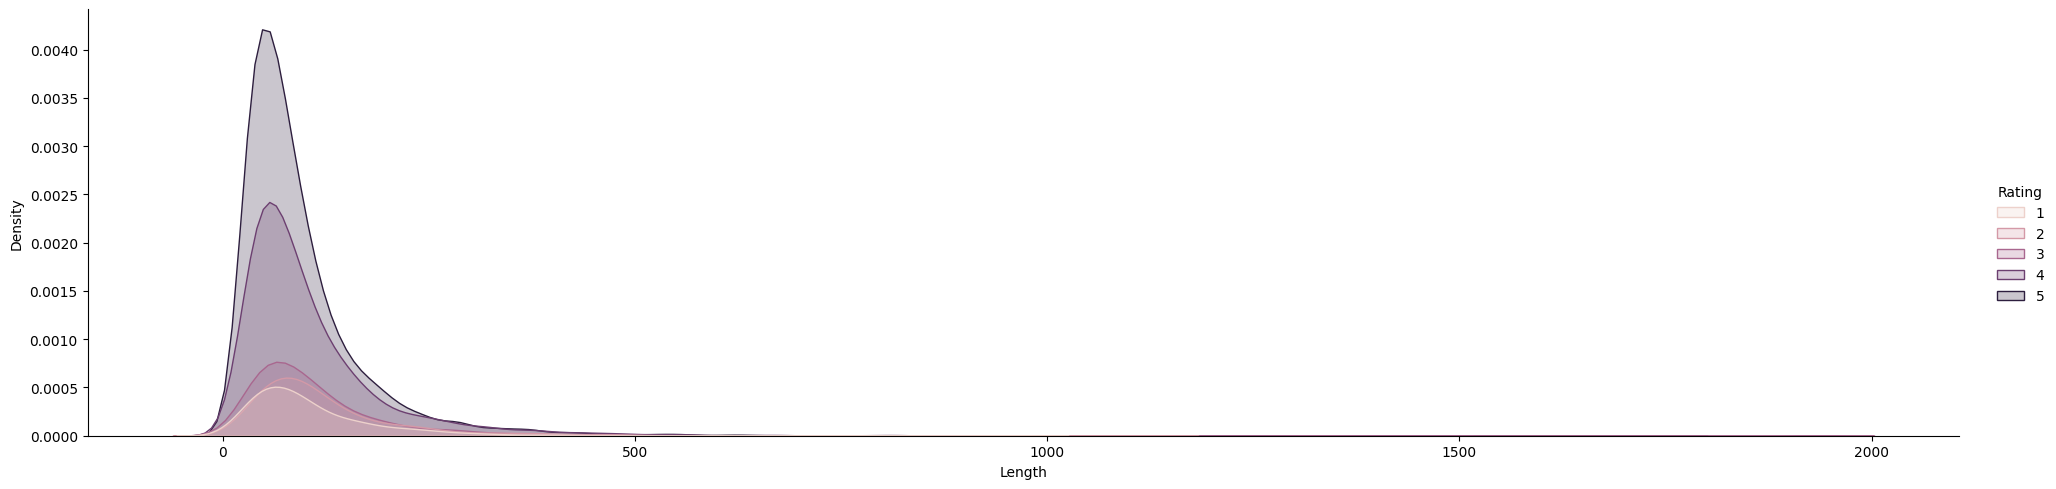

In [7]:
sns.displot(data=df, x='Length', hue='Rating', kind='kde', fill=True, aspect=4)
plt.show()

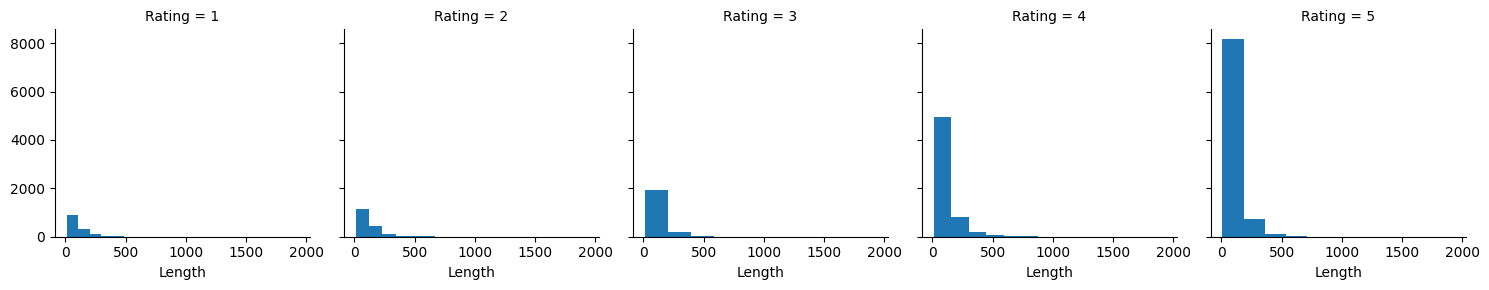

In [8]:
g = sns.FacetGrid(data=df, col='Rating')
g.map(plt.hist, 'Length')
plt.show()

# 3.Text Processing

In [9]:
# Let's change the rating to be more general and easier to understand
def rating(score):
    if score > 3:
        return 2 # Good
    elif score == 3:
        return 1 # Neutral
    else:
        return 0 # Bad

In [10]:
df['Rating'] = df['Rating'].apply(rating)

In [11]:
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,2,89
1,ok nothing special charge diamond member hilto...,0,252
2,nice rooms not 4* experience hotel monaco seat...,1,219
3,"unique, great stay, wonderful time hotel monac...",2,91
4,"great stay great stay, went seahawk game aweso...",2,193


# 4.Stemming vs Lemmatization

In [12]:
print('Original:')
print(df['Review'][0])
print()

sentence = []
for word in df['Review'][0].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['Review'][0].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  

Stemming:
nice hotel expens park got good deal stay hotel anniversary, arriv late even took advic previous review did valet parking, check quick easy, littl disappoint non-exist view room room clean nice size, bed comfort woke stiff neck high pillows, not soundproof like heard music room night morn loud bang door open close hear peopl talk hallway, mayb just noisi neighbors, aveda bath produc

In [13]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [14]:
df['Review'] = df['Review'].apply(cleaning)

In [15]:
df['Length'] = df['Review'].apply(lambda r: len(r.split(" ")))
new_length = df['Length'].sum()

print('Total word after cleaning: {}'.format(new_length))

Total word after cleaning: 2063023


In [16]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10, 
                height=800,width=1600,background_color="white").generate(' '.join(df['Review']))
print(wc)

<Figure size 2000x2000 with 0 Axes>

# Train test split & creating model

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Rating'], test_size=0.2)

In [18]:
# build vocabulary, convert text => number
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=80)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=80)

Total distinct words: 64787


In [19]:
y_test.head()

20387    2
804      2
7379     2
17468    2
18139    2
Name: Rating, dtype: int64

In [20]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [21]:
class SentimentAnalysis(torch.nn.Module):

    def __init__(self, total_word, embed_size, hidden_size, num_class, padding_index=0):
        super().__init__()
        self.total_word = total_word
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_class = num_class
        
        self.embed = torch.nn.Embedding(num_embeddings=total_word, 
                                        embedding_dim=embed_size, 
                                        padding_idx=padding_index)
        self.lstm = torch.nn.LSTM(input_size=self.embed_size, 
                                  hidden_size=self.hidden_size, 
                                  num_layers=1,
                                  bidirectional=True,
                                  batch_first=True)
        self.classifier = torch.nn.Sequential(
            # TODO: add more Linear layer, Activation layer
            torch.nn.Linear(in_features=2*self.hidden_size, out_features=num_class)
        )
        
    def forward(self, X):
        out = self.embed(X)
        out, _ = self.lstm(out)
        out = self.classifier(out[:, -1, :])
        return out

In [22]:
NUM_VOCAB = total_word
EMBED_SIZE = 128
HIDDEN_SIZE = 164
NUM_CLASS = 3
BATCH_SIZE = 64
EPOCH = 5

In [23]:
model = SentimentAnalysis(total_word=NUM_VOCAB, embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, num_class=NUM_CLASS)

In [24]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)


In [25]:
#TODO: build training loop to optimize model Sentiment Analysis

# Pseudocode:
# for each epoch:
# --> shuffle train data
# --> for each batch: 
# --> --> forward()
# --> --> compute loss
# --> --> backward()
num_train = X_train.shape[0]
inds = np.arange(num_train)
for e in range(EPOCH):
    np.random.shuffle(inds)
    pbar = tqdm(range(0, X_train.shape[0], BATCH_SIZE), desc="Epoch {}".format(e+1))
    for i in pbar:
        x = torch.Tensor(X_train[inds[i:i+BATCH_SIZE]])
        x = x.type(dtype=torch.IntTensor)
        y_hat = model(x)
        y = torch.Tensor(y_train[inds[i:i+BATCH_SIZE]])
        y = y.type(dtype=torch.LongTensor)
        loss = loss_func(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description("Epoch: {} - Loss: {}".format(e+1, loss.item()))

Epoch: 5 - Loss: 0.5825990438461304: 100%|██████████| 257/257 [01:25<00:00,  2.99it/s]


In [26]:
model.eval()
with torch.no_grad():
    x = torch.Tensor(X_test)
    x = x.type(dtype=torch.IntTensor)
    y_hat = model(x)

In [27]:
pred = y_hat.argmax(-1)
pred = pred.cpu().numpy()

In [28]:
print("Accuracy:", np.sum(pred == y_test)/y_test.shape[0])

Accuracy: 0.7755550134179068
